# Loading testing data and best model

In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from glob import glob
import matplotlib.colors as mcolors
# PyTorch Libraries
import torch
from ref_model_hypercol.models import UNetResNextHyperSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#For reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [4]:
# Load the best model

model = UNetResNextHyperSE(encoder_depth=50, num_classes=7, num_filters=32, dropout_2d=0.2, is_deconv=True)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

C:\Users\johnh\AppData\Local\Temp\ipykernel_17788\1269037132.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


UNetResNextHyperSE(
  (encoder): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

## Loading test data files

In [5]:
# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

#Location of test files
testimage_dir = './images/test/2023'
label_test = './labels/test'

# Get names of image and label files for test
testimage_files = sorted(glob(os.path.join(testimage_dir, '*.tif')))
testlabel_files = sorted(glob(os.path.join(label_test, '*.tif')))

# Plotting truth vs prediction

In [6]:
# Function to open and process image files (for RGB bands 3, 2, 1)
def process_image(file):
    with rasterio.open(file) as src:
        # Read the RGB bands (3, 2, 1)
        rgb = np.dstack([src.read(3), src.read(2), src.read(1)])
        # Normalize RGB for better visualization
        rgb = rgb.astype(float)
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    return rgb

# Read in the 7 channels of data for all the images in fileList
def extract_channels(file):
    with rasterio.open(file) as src:
        data = np.dstack([src.read(7), src.read(6), src.read(5), src.read(4), src.read(3), src.read(2), src.read(1)])
    return np.expand_dims(data, axis=0) #Expand dims to allow as model input

# FUnction to read the labels of one file
def process_label(file):
    with rasterio.open(file) as lbl_src:
        labels = lbl_src.read(1)  # Read the first band which contains the labels
    return labels

In [27]:
#Plot a testing image, its true labels and the labels predicted by the model
def plot_truth_and_prediction(testimage_files, testlabel_files, model, label_names, indice = None):

    #If no indice is given, pick a random
    if indice is None:
        indice = random.sample(range(len(testimage_files)), 1)
    
    img_file = testimage_files[indice]
    lbl_file = testlabel_files[indice]
    
    rgb = process_image(img_file)
    labels = process_label(lbl_file)

    #Get whole test file data
    testimage = extract_channels(img_file)
    testimage = torch.tensor(testimage).float().permute(0, 3, 1, 2)  # HWC to CHW

    # Move data to the appropriate device
    testimage = testimage.to(device)

    #Predict the labels
    with torch.no_grad():

        outputs = model(testimage)
        prediction_values = torch.argmax(outputs, dim=1).cpu().numpy()  # Convert predictions to numpy array


    ###### Plotting
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Create a consistent Normalize object for colouring
    norm = mcolors.Normalize(vmin=0, vmax=len(label_names) - 1)
    cmap = plt.cm.tab20  # Colormap for labels

    # set matplotlib font
    plt.rcParams.update({'font.size':15})

    # Plot the RGB image
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title(f"Image: {os.path.basename(img_file)}")
    axes[0, 0].axis('off')

    # Plot the label map
    im = axes[0, 1].imshow(labels, cmap=cmap, norm=norm)
    axes[0, 1].set_title(f"Labels: {os.path.basename(lbl_file)}")
    axes[0, 1].axis('off')

    # Plot the label map
    axes[1, 0].axis('off')
    axes[1, 0].set_xlim(0, 2)
    axes[1, 0].set_title("Label Legend")
    for i, label in enumerate(label_names):
        color = cmap(norm(i))  # Get the color for each label
        axes[1, 0].barh(i, 1, color=color, edgecolor="black", align="center")
        axes[1, 0].text(1.1, i, label, va='center', fontsize=15)

    #Plot the prediction label map
    im = axes[1, 1].imshow(prediction_values[0], cmap=cmap, norm=norm)
    axes[1, 1].set_title(f"Predicted labels")
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

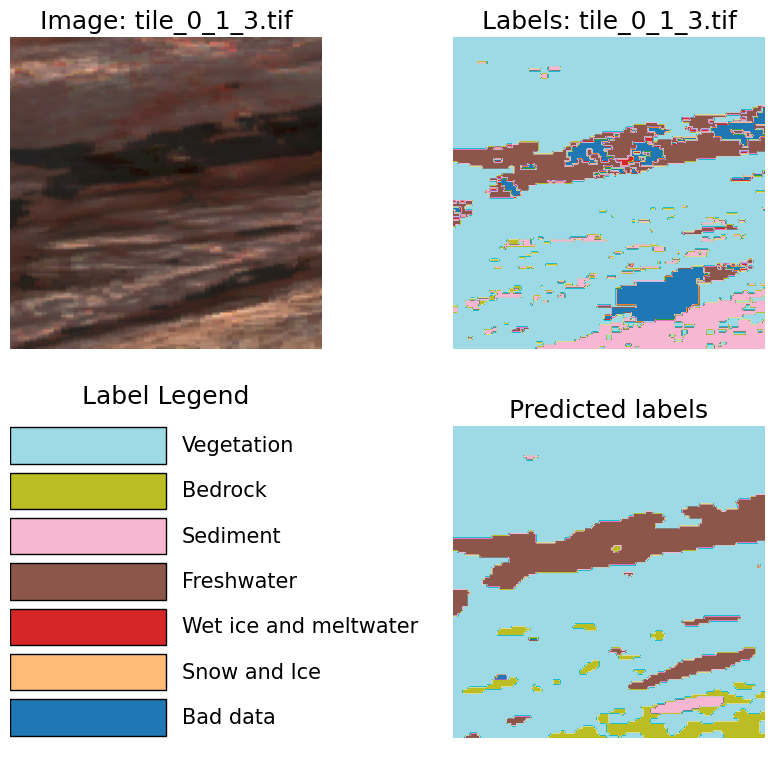

In [28]:
plot_truth_and_prediction(testimage_files, testlabel_files, model, label_names, indice = 0)

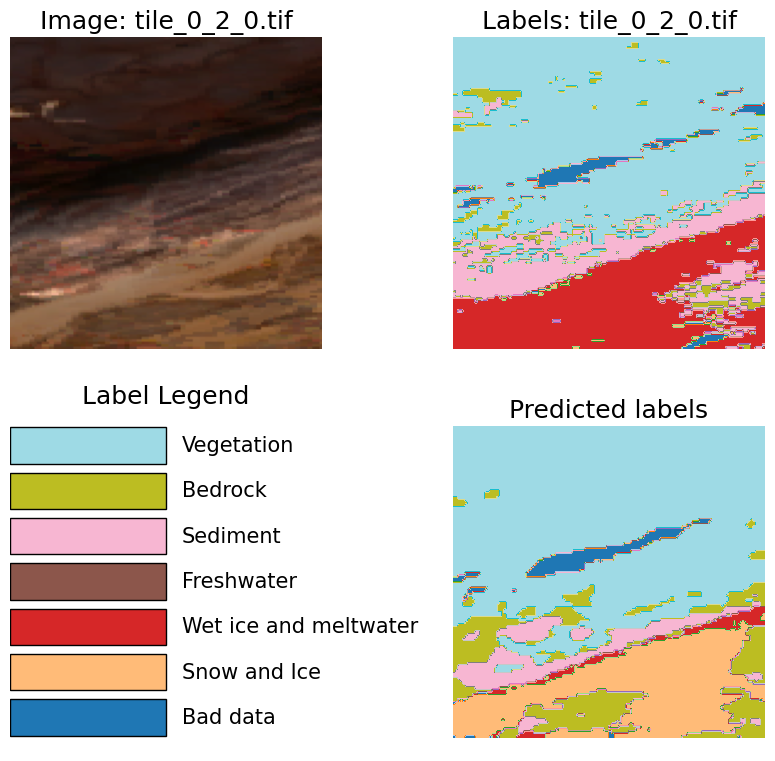

In [29]:
plot_truth_and_prediction(testimage_files, testlabel_files, model, label_names, indice = 1)